<a href="https://colab.research.google.com/github/spdavis5/ai-stylistic-fingerprints/blob/main/process_and_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Imports

# For preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub

In [8]:
#Load data

#Change this to select different datasets
dataset_number = 1

if dataset_number == 1:
    # https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text
    path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")
    csv_path = os.path.join(path, "AI_Human.csv")
    df = pd.read_csv(
        csv_path,
        encoding="utf-8",
    )
    df.head()
elif dataset_number == 2:
# https://huggingface.co/datasets/shahxeebhassan/human_vs_ai_sentences
    df = pd.read_csv("hf://datasets/shahxeebhassan/human_vs_ai_sentences/complete_dataset.csv")
    # This specific data is has the column called 'label' rather than 'generated'. Change this for consistency
    df = df.rename(columns={'label': 'generated'})
elif dataset_number == 3:
# https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset
    path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")
    csv_path = os.path.join(path, "Training_Essay_Data.csv")
    df = pd.read_csv(
        csv_path,
        encoding="utf-8"
    )

Using Colab cache for faster access to the 'ai-vs-human-text' dataset.


In [9]:
#Initial row count
print(f"Initial row count: {df.shape[0]}")

# ensure text is string
df['text'] = df['text'].astype(str)

# Drop missing text
df = df.dropna(subset=['text']).copy()

# If outer quotes exist, strip them for cleaner data
cleaned = []
for val in df["text"]:
    if len(val) >= 2 and val[0] == val[-1] and val[0] in ["'", '"']:
        cleaned.append(val[1:-1])
    else:
        cleaned.append(val)
df["text"] = cleaned

# Drop rows with text <30 characters or all-caps text
df = df.loc[
    (df['text'].str.len() >= 30) &
    (
        (~df['text'].str.contains(r'[A-Za-z]', na=False)) |
        (df['text'].str.contains(r'[a-z]', na=False))
    )
].copy()

# Replace newlines, tabs with spaces
df['text'] = df['text'].str.replace(r'[\n\t]', ' ', regex=True)

# Replace multiple spaces with a single space (e.g. "Hello    World" -> "Hello World")
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

# Trim leading/trailing whitespace
df['text'] = df['text'].str.strip()

# Drop duplicates based
df.drop_duplicates(subset=['text'], inplace=True)

#Reset index just in case
df.reset_index(drop=True, inplace=True)

# Final row count
print(f"Final row count: {df.shape[0]}")

Initial row count: 487235
Final row count: 464686


Dataset Statistics:
Total Samples: 464,686
Human Texts: 284,910
AI Texts: 179,776
Avg Length: 2266 characters


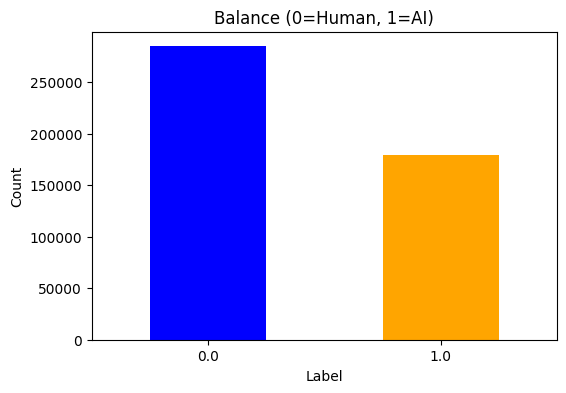

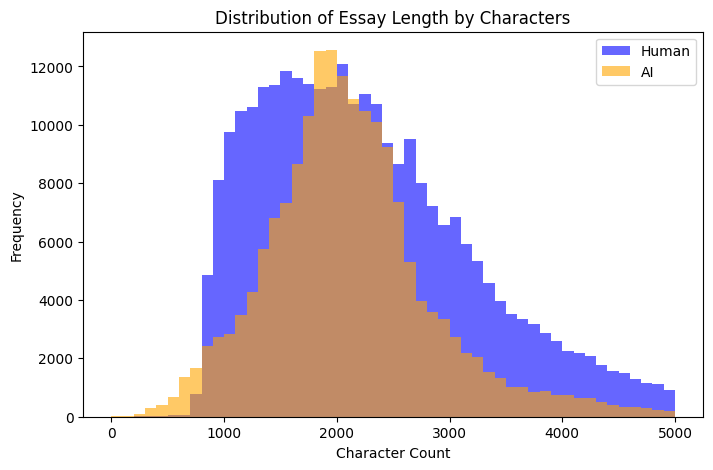

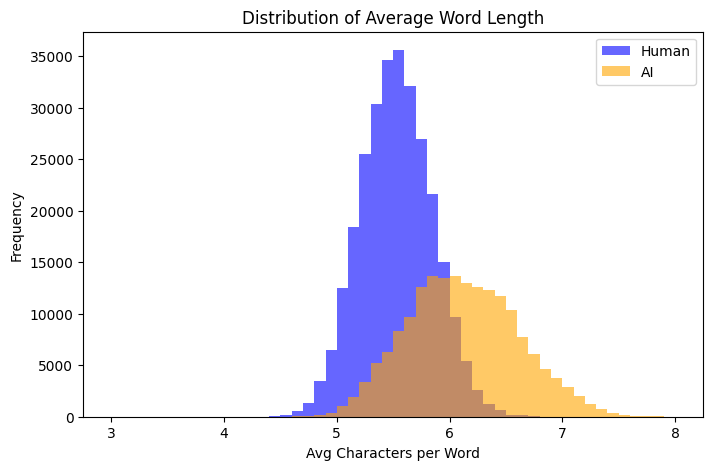

In [10]:
print("Dataset Statistics:")
total_human = len(df[df['generated'] == 0])
total_ai = len(df[df['generated'] == 1])
avg_len = int(df['text'].str.len().mean())

print(f"Total Samples: {len(df):,}")
print(f"Human Texts: {total_human:,}")
print(f"AI Texts: {total_ai:,}")
print(f"Avg Length: {avg_len} characters")

# Balance Plot
plt.figure(figsize=(6, 4))
df['generated'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Balance (0=Human, 1=AI)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Text Length Plot
df['char_count'] = df['text'].str.len()

plt.figure(figsize=(8, 5))
plt.hist(df[df['generated']==0]['char_count'], bins=50, alpha=0.6, label='Human', color='blue', range=(0,5000))
plt.hist(df[df['generated']==1]['char_count'], bins=50, alpha=0.6, label='AI', color='orange', range=(0,5000))
plt.title("Distribution of Essay Length by Characters")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Average Word Length Plot
df['word_count'] = df['text'].str.split().str.len()
df['avg_word_len'] = df['char_count'] / df['word_count']

plt.figure(figsize=(8, 5))
plt.hist(df[df['generated']==0]['avg_word_len'], bins=50, alpha=0.6, label='Human', color='blue', range=(3, 8))
plt.hist(df[df['generated']==1]['avg_word_len'], bins=50, alpha=0.6, label='AI', color='orange', range=(3, 8))
plt.title("Distribution of Average Word Length")
plt.xlabel("Avg Characters per Word")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [6]:
#Export data (only text and label columns)
df = df[['text', 'generated']]
df.to_csv(f'processed_dataset{dataset_number}.csv', index=False)